# Text Classification - Basic (TF2)

https://www.tensorflow.org/tutorials/keras/text_classification?hl=ko

In [1]:
# 경고 메시지 출력 끄기
import warnings 
warnings.filterwarnings(action='ignore')

# 노트북 셀 표시를 브라우저 전체 폭 사용하기
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import clear_output

%matplotlib inline
import matplotlib.pyplot as plt

import sys

rseed = 22
import random
random.seed(rseed)

import numpy as np
np.random.seed(rseed)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind': "{:.5f}".format})

import pandas as pd
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.5f}'.format

import tensorflow as tf
tf.random.set_seed(rseed)
tf.keras.backend.set_floatx('float32') # keras default float type 설정

print(f"python ver={sys.version}")
print(f"pandas ver={pd.__version__}")
print(f"numpy ver={np.__version__}")
print(f"tensorflow ver={tf.__version__}")

python ver=3.7.6 (default, Nov 21 2020, 22:51:13) 
[Clang 12.0.0 (clang-1200.0.32.27)]
pandas ver=1.0.5
numpy ver=1.19.5
tensorflow ver=2.4.1


## 영화 리뷰를 사용한 텍스트 분류

영화 리뷰 텍스트를 긍정(positive) 또는 부정(negative)으로 분류합니다. 이 예제는 binary classification(이진분류) 문제입니다. 

여기에서는 인터넷 영화 데이터베이스(Internet Movie Database)에서 수집한 50,000개의 영화 리뷰 텍스트를 담은 IMDB 데이터셋을 사용합니다.
25,000개 리뷰는 훈련용으로, 25,000개는 테스트용으로 나뉘어져 있으며, 훈련 세트와 테스트 세트의 클래스는 균형이 잡혀 있습니다. 즉 긍정적인 리뷰와 부정적인 리뷰의 개수가 동일합니다.

### IMDB 데이터셋 다운로드

매개변수 num_words=10000은 훈련 데이터에서 가장 많이 등장하는 상위 10,000개의 단어를 어휘 사전으로 선택합니다. 데이터 크기를 적당하게 유지하기 위해 드물에 등장하는 단어는 제외하겠습니다.

In [2]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data
imdb = tf.keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

### 데이터 탐색

이 데이터셋의 샘플은 전처리된 정수 배열입니다. 이 정수는 영화 리뷰에 나오는 단어를 나타냅니다. 레이블(label)은 정수 0 또는 1입니다. 0은 부정적인 리뷰이고 1은 긍정적인 리뷰입니다.

In [3]:
print(f"shape: train_data={train_data.shape}, train_labels: {train_labels.shape}")
print(f"sample: train_data={train_data[0]}, \ntrain_labels: {train_labels[0]}")

# 영화 리뷰들은 길이가 다릅니다. 다음 코드는 첫 번째 리뷰와 두 번째 리뷰에서 단어의 개수를 출력합니다. 신경망의 입력은 길이가 같아야 하기 때문에 나중에 이 문제를 해결하겠습니다.
print(f"len: sample0={len(train_data[0])}, sample1={len(train_data[1])}")

shape: train_data=(25000,), train_labels: (25000,)
sample: train_data=[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19,

정수를 단어로 다시 변환하기

In [4]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()
print(f"len: word_index={len(word_index)}") # 전체 인덱스는 88,584 개 이지만, 이 중 우리는 상위 빈도 10,000 개의 단어만 사용하는 전처리된 데이터 셋을 사용합니다.
    
# 몇가지 사전 정의된 값을 설정하기 위해 기존 word_index 값을 일괄 조정 후, 앞쪽에 해당 정의된 Key, Value 값을 저장합니다.
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

# 역 인덱스를 만들어 정수 배열 데이터를 글로 변환 합니다.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[0])

len: word_index=88584


"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 데이터 준비

리뷰(정수 배열)은 신경망에 주입하기 전에 텐서로 변환되어야 합니다. 변환하는 방법에는 몇 가지가 있습니다:

원-핫 인코딩(one-hot encoding)은 정수 배열을 0과 1로 이루어진 벡터로 변환합니다. 예를 들어 배열 [3, 5]을 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000차원 벡터로 변환할 수 있습니다. 그다음 실수 벡터 데이터를 다룰 수 있는 Dense 레이어를 신경망의 첫 번째 레이어으로 사용합니다. 이 방법은 num_words * num_reviews 크기의 행렬이 필요하기 때문에 메모리를 많이 사용합니다.

다른 방법으로는, 정수 배열의 길이가 모두 같도록 패딩(padding)을 추가해 max_length * num_reviews 크기의 정수 텐서를 만듭니다. 이런 형태의 텐서를 다룰 수 있는 임베딩(embedding) 층을 신경망의 첫 번째 레이어로 사용할 수 있습니다.

이 튜토리얼에서는 두 번째 방식을 사용하겠습니다.

영화 리뷰의 길이가 같아야 하므로 [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences?hl=ko) 함수를 사용해 길이를 맞춥니다.

In [5]:
# padding='post': padding을 뒷쪽에 넣어줌
# value=word_index["<PAD>"]: word_index["<PAD>"] 값인 0을 넣어줌
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data, value=word_index["<PAD>"], padding='post', maxlen=256)
test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data, value=word_index["<PAD>"], padding='post', maxlen=256)

In [6]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [7]:
print(train_data[0])
print(len(word_index))

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### 모델 구성

신경망은 레이어(layer)을 쌓아서 만듭니다. 이 구조에서는 두 가지를 결정해야 합니다:

* 모델에서 얼마나 많은 레이어를 사용할 것인가?
* 각 레이어에서 얼마나 많은 히든 유닛(hidden unit)을 사용할 것인가?

이 예제의 입력 데이터는 단어 인덱스의 배열입니다. 예측할 레이블은 0 또는 1입니다. 이 문제에 맞는 모델을 구성합니다.

레이어를 순서대로 쌓아 분류기(classifier)를 만듭니다:

* 첫 번째 레이어는 Embedding 레이어입니다. 이 층은 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이 벡터는 모델이 훈련되면서 학습됩니다. 이 벡터는 출력 배열에 새로운 차원으로 추가됩니다. 최종 차원은 (batch, sequence, embedding)이 됩니다.
* 두 번째 레이어는 GlobalAveragePooling1D 레이어입니다. sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법입니다.
* 세 번째 레이어는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) Dense 레이어를 거칩니다.
* 마지막 레이어는 1 output 을 가지는 Dense 레이어입니다. sigmoid 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

**은닉 유닛**

위 모델에는 입력과 출력 사이에 두 개의 중간 또는 "은닉" 레이어가 있습니다. 출력(유닛 또는 노드, 뉴런)의 개수는 레이어가 가진 표현 공간(representational space)의 차원이 됩니다. 다른 말로 하면, 내부 표현을 학습할 때 허용되는 네트워크 자유도의 양입니다.

모델에 많은 은닉 유닛(고차원의 표현 공간)과 레이어가 있다면 네트워크는 더 복잡한 표현을 학습할 수 있습니다. 하지만 네트워크의 계산 비용이 많이 들고 원치않는 패턴을 학습할 수도 있습니다. 이런 표현은 훈련 데이터의 성능을 향상시키지만 테스트 데이터에서는 그렇지 못합니다. 이를 과대적합(overfitting)이라고 부릅니다. 나중에 이에 대해 알아 보겠습니다.

In [8]:
# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기입니다 (빈도 상위: 10,000개의 단어)
vocab_size = 10000

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### 손실 함수와 옵티마이저

모델이 훈련하려면 손실 함수(loss function)과 옵티마이저(optimizer)가 필요합니다. 이 예제는 이진 분류 문제이고 모델이 확률을 출력하므로(출력층의 유닛이 하나이고 sigmoid 활성화 함수를 사용합니다), binary_crossentropy 손실 함수를 사용하겠습니다.

다른 손실 함수를 선택할 수 없는 것은 아닙니다. 예를 들어 mean_squared_error를 선택할 수 있습니다. 하지만 일반적으로 binary_crossentropy가 확률을 다루는데 적합합니다. 이 함수는 확률 분포 간의 거리를 측정합니다. 여기에서는 정답인 타깃 분포와 예측 분포 사이의 거리입니다.

나중에 회귀(regression) 문제(예를 들어 주택 가격을 예측하는 문제)에 대해 살펴 볼 때 평균 제곱 오차(mean squared error) 손실 함수를 어떻게 사용하는지 알아 보겠습니다.

이제 모델이 사용할 옵티마이저와 손실 함수를 설정해 보겠습니다:

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 검증 세트 만들기

모델을 훈련할 때 모델이 만난 적 없는 데이터에서 정확도를 확인하는 것이 좋습니다. 원본 훈련 데이터에서 10,000개의 샘플을 떼어내어 검증 세트(validation set)를 만들겠습니다. (왜 테스트 세트를 사용하지 않을까요? 훈련 데이터만을 사용하여 모델을 개발하고 튜닝하는 것이 목표입니다. 그다음 테스트 세트를 사용해서 딱 한 번만 정확도를 평가합니다).

In [10]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### 모델 훈련

이 모델을 512개의 샘플로 이루어진 미니배치(mini-batch)에서 40번의 에포크(epoch) 동안 훈련합니다. x_train과 y_train 텐서에 있는 모든 샘플에 대해 40번 반복한다는 뜻입니다. 훈련하는 동안 10,000개의 검증 세트에서 모델의 손실과 정확도를 모니터링합니다:

In [11]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 30ms/step - loss: 0.6924 - accuracy: 0.5572 - val_loss: 0.6886 - val_accuracy: 0.6994
Epoch 2/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6861 - accuracy: 0.6734 - val_loss: 0.6793 - val_accuracy: 0.7313
Epoch 3/40
30/30 [==============================] - 0s 12ms/step - loss: 0.6744 - accuracy: 0.7286 - val_loss: 0.6629 - val_accuracy: 0.7533
Epoch 4/40
30/30 [==============================] - 0s 12ms/step - loss: 0.6536 - accuracy: 0.7701 - val_loss: 0.6376 - val_accuracy: 0.7700
Epoch 5/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6239 - accuracy: 0.7886 - val_loss: 0.6050 - val_accuracy: 0.7903
Epoch 6/40
30/30 [==============================] - 0s 14ms/step - loss: 0.5849 - accuracy: 0.8101 - val_loss: 0.5660 - val_accuracy: 0.7991
Epoch 7/40
30/30 [==============================] - 0s 14ms/step - loss: 0.5440 - accuracy: 0.8224 - val_loss: 0.5259 - val_accuracy: 0.8150
Epoch 8/40
30

## 모델 평가

모델의 성능을 확인해 보죠. 두 개의 값이 반환됩니다. 손실(오차를 나타내는 숫자이므로 낮을수록 좋습니다)과 정확도입니다. 이 예제는 매우 단순한 방식을 사용하므로 87% 정도의 정확도를 달성했습니다. 고급 방법을 사용한 모델은 95%에 가까운 정확도를 얻습니다.

In [12]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 0s - loss: 0.3241 - accuracy: 0.8729
[0.3240858316421509, 0.8728799819946289]


### 정확도와 손실 그래프 그리기

model.fit()은 History 객체를 반환합니다. 여기에는 훈련하는 동안 일어난 모든 정보가 담긴 딕셔너리(dictionary)가 들어 있습니다:

훈련과 검증 단계에서 모니터링하는 지표들입니다. 훈련 손실과 검증 손실을 그래프로 그려 보고, 훈련 정확도와 검증 정확도도 그래프로 그려서 비교해 보겠습니다:

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

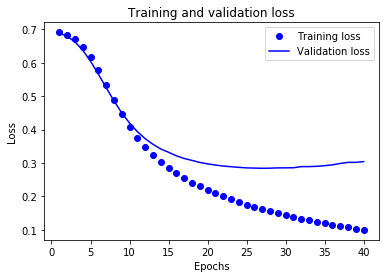

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

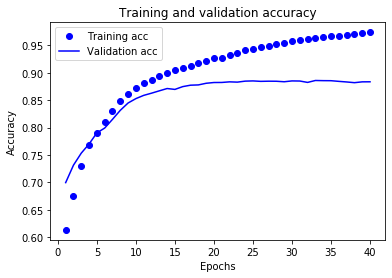

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 그래프에서 점선은 훈련 손실과 훈련 정확도를 나타냅니다. 실선은 검증 손실과 검증 정확도입니다.

훈련 손실은 에포크마다 감소하고 훈련 정확도는 증가한다는 것을 주목하세요. 경사 하강법 최적화를 사용할 때 볼 수 있는 현상입니다. 매 반복마다 최적화 대상의 값을 최소화합니다. 하지만 검증 손실과 검증 정확도에서는 그렇지 못합니다. 

**약 20번째 에포크 이후가 최적점인 것 같습니다.** 이는 과대적합 때문입니다. 이전에 본 적 없는 데이터보다 훈련 데이터에서 더 잘 동작합니다. 이 지점부터는 모델이 과도하게 최적화되어 테스트 데이터에서 일반화되기 어려운 훈련 데이터의 특정 표현을 학습합니다.

여기에서는 과대적합을 막기 위해 단순히 20번째 에포크 근처에서 훈련을 멈출 수 있습니다. 나중에 콜백(callback)을 사용하여 자동으로 이렇게 하는 방법을 배워 보겠습니다.

In [16]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.